In [13]:
### tol 5 o 3??

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

In [15]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [16]:
label_names = ['not app', 'no person', 'yes', 'no'] # Q4: Person wearing fashion?
folder = "./Fashion10000/"

### Load Data and preprocess

In [17]:
X_vgg16 = np.load(folder+"Fashion10000_VGG_avg_all.npy")
X_vgg16.shape

(31077, 512)

In [18]:
Q_s = "Q4" #question selected
p_error = "0.6" #Q3: cerca de 82-84.. valores varian 2% 

In [22]:
sets = np.loadtxt(folder+"sets_"+p_error+"_"+Q_s+".txt", dtype='U')
mask_train = sets == "train"
mask_test = sets == "test"

Z_data = np.loadtxt(folder+"Z_data_"+Q_s+".txt",dtype='int')
Z_train = Z_data[mask_train]
Z_test = Z_data[mask_test]

X_train_vgg16 = X_vgg16[mask_train]
X_test_vgg16 = X_vgg16[mask_test]

X_val_vgg16 = X_test_vgg16
Z_val = Z_test

print("Input train shape:",X_train_vgg16.shape)
print("Label train shape:",Z_train.shape)

print("Input test shape:",X_test_vgg16.shape)
print("Label test shape:",Z_test.shape)

Input train shape: (25137, 512)
Label train shape: (25137,)
Input test shape: (1968, 512)
Label test shape: (1968,)


In [27]:
## create new test...
mask_val = np.random.rand(Z_train.shape[0]) < 0.25 #0.33

mask_test[mask_train] = mask_val #test selected to be test
mask_train[mask_train] = ~mask_val #train extracted to be test..

mask_sets = np.asarray(["aux" for _ in range(Z_data.shape[0])]).astype("U5")
mask_sets[mask_train] = "train"
mask_sets[mask_test] = "test"

y_obs = np.loadtxt(folder+"answers_"+p_error+"_"+Q_s+".txt",dtype='int16')#not annotation symbol ==-1

np.savetxt(folder+"sets_"+p_error+"_"+Q_s+".txt", mask_sets,delimiter=' ', fmt='%s')
np.savetxt(folder+"answers_"+p_error+"_"+Q_s+".txt", y_obs[~mask_val], delimiter=' ', fmt='%d')

KeyboardInterrupt: 

In [7]:
#created before..
mask_val = np.random.rand(Z_train.shape[0]) < 0.33 #0.25 #0.33

In [63]:
X_val_vgg16 = X_train_vgg16[mask_val]
X_train_vgg16 = X_train_vgg16[~mask_val]
Z_val = Z_train[mask_val]
Z_train = Z_train[~mask_val]

X_val_vgg16 = np.concatenate([X_val_vgg16,X_test_vgg16])
Z_val = np.concatenate([Z_val,Z_test])


print("Input train shape:",X_train_vgg16.shape)
print("Label train shape:",Z_train.shape)

print("Input val shape:",X_val_vgg16.shape)
print("Label val shape:",Z_val.shape)

Input train shape: (18201, 512)
Label train shape: (18201,)
Input val shape: (8904, 512)
Label val shape: (8904,)


In [23]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [70]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler().fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)

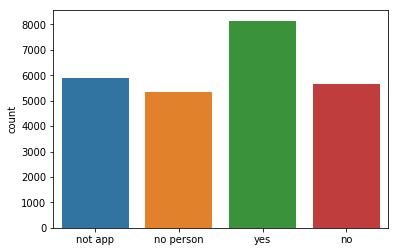

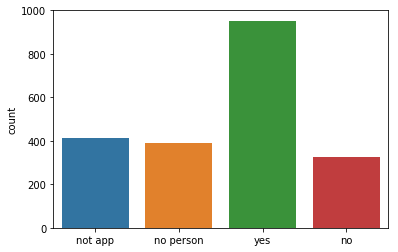

In [12]:
sns.countplot(Z_train)
plt.xticks(np.arange(len(label_names)), label_names)
plt.show()

sns.countplot(Z_test)
plt.xticks(np.arange(len(label_names)), label_names)
plt.show()

### Load annotations / Generate

In [24]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers_"+p_error+"_"+Q_s+".txt",dtype='int16')#not annotation symbol ==-1
#y_obs = y_obs[~mask_val]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 0 annotators that do not annotate on this set 
Shape (data,annotators):  (25137, 1389)
Classes:  4


In [ ]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

In [30]:
np.savetxt(folder+"answers_v2.txt",new_annotations, delimiter=",", fmt="%i")

In [25]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.49019608, 0.23529412, 0.11764706, 0.15686275],
        [0.04166667, 0.625     , 0.1875    , 0.14583333],
        [0.        , 0.        , 0.8867925 , 0.11320755],
        [0.        , 0.        , 0.7906977 , 0.20930232]],

       [[1.        , 0.        , 0.        , 0.        ],
        [0.67741936, 0.29032257, 0.        , 0.03225806],
        [0.        , 0.        , 0.46666667, 0.53333336],
        [0.2       , 0.05      , 0.05      , 0.7       ]],

       [[0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.5       , 0.5       ]],

       ...,

       [[0.25      , 0.25      , 0.25      , 0.25      ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.25      , 0.25      , 0.25      , 0.25      ],
        [1.        , 0.        , 0.        , 0.        ]],

       [[0.        , 1.        , 0.        , 0.    

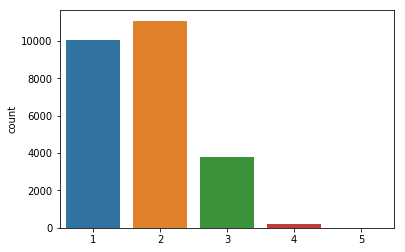

Minimum annotations in a example:  1
Maximum annotations in a example:  5
T data (expected value):  1.7667979472490751
Graphics of T weights


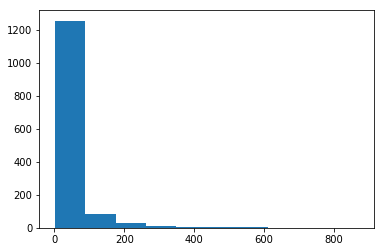

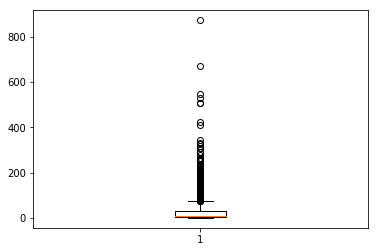

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  872
Mean annotations by an annotator:  31.974082073434126


In [26]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [27]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [28]:
Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=Kl)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=True,drop=0.5) 

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

clone_UB = Clonable_Model(model_UB)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_val_pred = model_UB.predict_classes(Xstd_val)
Z_test_pred = model_UB.predict_classes(Xstd_test)

InternalError: Blas GEMM launch failed : a.shape=(128, 512), b.shape=(512, 128), m=128, n=128, k=512
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/dense_1/MatMul_grad/MatMul_1"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_1_0_3/_75, dense_1/kernel/read)]]
	 [[Node: loss/mul/_129 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_855_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'dense_1/MatMul', defined at:
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-031d80152ac5>", line 3, in <module>
    model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=True,drop=0.5)
  File "/home/fmena/Desktop/Dataset_Tesis/MixtureofGroups/code/learning_models.py", line 50, in MLP_Keras
    model.add(Dense(units,activation='relu'))
  File "/home/fmena/.local/lib/python3.5/site-packages/keras/models.py", line 522, in add
    output_tensor = layer(self.outputs[0])
  File "/home/fmena/.local/lib/python3.5/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/fmena/.local/lib/python3.5/site-packages/keras/layers/core.py", line 877, in call
    output = K.dot(inputs, self.kernel)
  File "/home/fmena/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1076, in dot
    out = tf.matmul(x, y)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 2122, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4279, in mat_mul
    name=name)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(128, 512), b.shape=(512, 128), m=128, n=128, k=512
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/dense_1/MatMul_grad/MatMul_1"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_1_0_3/_75, dense_1/kernel/read)]]
	 [[Node: loss/mul/_129 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_855_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [52]:
Kl = Z_train.max()+1
Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=Kl)
Z_val_onehot = keras.utils.to_categorical(Z_val, num_classes=Kl)
Z_test_onehot = keras.utils.to_categorical(Z_test, num_classes=Kl)

In [53]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,2,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total para

In [54]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=True,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 66,692
Trainable params: 66,436
Non-trainable params: 256
_________________________________________________________________
Trai

In [55]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,2,BN=True,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [87]:
clone_UB = Clonable_Model(model_UB)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 4


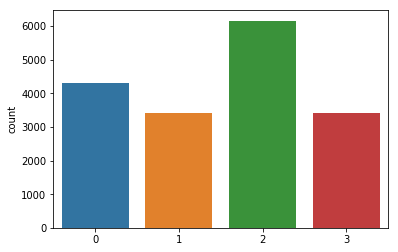

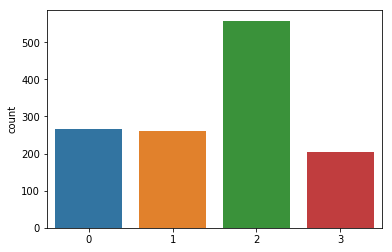

In [91]:
sns.countplot(Z_train_pred)
plt.show()
sns.countplot(Z_test_pred)
plt.show()

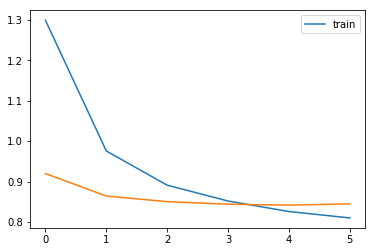

In [92]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [33]:
from code.evaluation import Evaluation_metrics

N = Xstd_train.shape[0]
evaluate = Evaluation_metrics(model_UB,'keras',N)
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.8238,0.8238,0.8109


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.843,0.843,0.825


### Infer Labels (without predictive model)

In [ ]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

In [ ]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("F1 MV  on train:",f1_score(Z_train,mv_onehot.argmax(axis=1),average="macro"))

print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))
print("F1 D&S  on train:",f1_score(Z_train,ds_labels.argmax(axis=1),average="macro"))

In [ ]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_val_pred = model_mvsoft.predict_classes(Xstd_val)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

In [ ]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_val_pred = model_mvhard.predict_classes(Xstd_val)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

In [ ]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_val_pred = model_ds.predict_classes(Xstd_val)
Z_test_pred = model_ds.predict_classes(Xstd_test)

### Raykar Model (joint predict model)

In [ ]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

In [ ]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=True,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

In [ ]:
Z_train_p = raykarMC.get_predictions(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_val_pred = raykarMC.get_predictions(Xstd_val).argmax(axis=-1)
Z_test_pred = raykarMC.get_predictions(Xstd_test).argmax(axis=-1)

### Our Proposed

In [159]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [ ]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups


#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

Normalized entropy (0-1) of repeats annotations: 0.06213511502976383


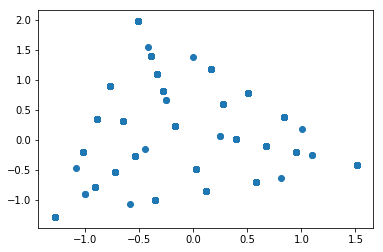

In [22]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.041659 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (17363, 4)
Betas:  (5, 4, 4)
Q estimate:  (17363, 4, 5, 4)
Iter 1/0
M step: done,  E step: done //  (in 1.06 sec)	logL: -67392.492	
Finished training!


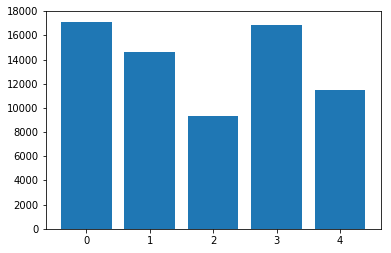

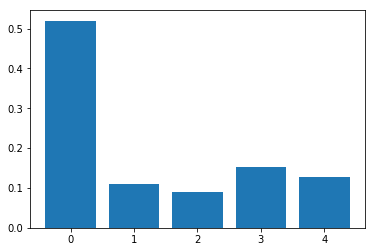

In [21]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=True,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())
plt.show()

In [20]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

459


NameError: name 'logL_Mchange' is not defined

1, 2 o 3...

In [ ]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [ ]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=True,drop=0.5)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

gMixture_Global.lambda_random = False 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*5/3)

In [ ]:
Z_train_p = gMixture_Global.get_predictions(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Global.get_predictions(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [167]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (1361, 1361)


shape of annotator representation (T, R_t)= (1361, 16)


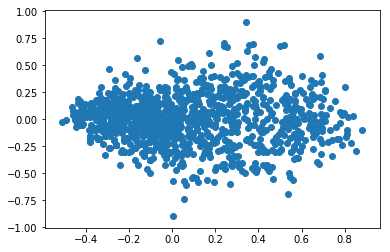

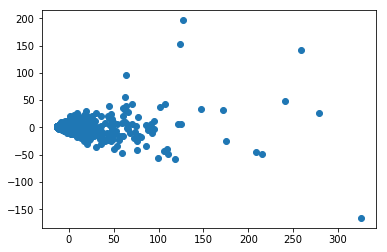

array([[25., 36., 83., 29.],
       [37.,  6.,  7., 21.],
       [ 2.,  2.,  8.,  4.],
       ...,
       [ 1.,  0.,  2.,  0.],
       [ 0.,  2.,  0.,  0.],
       [ 0.,  1.,  1.,  0.]])

In [168]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
#A_rep = np.zeros((conf_mat.shape[0], Kl))
#for t in range(A_rep.shape[0]):
#    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [169]:
#different M_seted??
M_seted = 3

In [170]:
gMixture_Ind1 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("mlp",128,1,BatchN=True,drop=0.5)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
gMixture_Ind1.define_model_group("perceptron",T, M_seted, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i = gMixture_Ind1.multiples_run(1,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL*5/3)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002219 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (19402, 4)
Betas:  (3, 4, 4)
Q estimate:  (37782, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 6.90 sec)	logL: -39787.774	
Iter 2/50
M step: done,  E step: done //  (in 1.87 sec)	logL: -38004.306	Tol1: 0.04482	Tol2: 0.23823	
Iter 3/50
M step: done,  E step: done //  (in 1.98 sec)	logL: -37124.403	Tol1: 0.02315	Tol2: 0.20678	
Iter 4/50
M step: done,  E step: done //  (in 2.01 sec)	logL: -36385.977	Tol1: 0.01989	Tol2: 0.18136	
Iter 5/50
M step: done,  E step: done //  (in 2.04 sec)	logL: -35787.638	Tol1: 0.01644	Tol2: 0.16163	
Iter 6/50
M step: done,  E step: done //  (in 1.88 sec)	logL: -35117.250	Tol1: 0.01873	Tol2: 0.16999	
Iter 7/50
M step: done,  E step: done //  (in 1.85 sec)	logL: -34558.808	Tol1: 0.01590	Tol2: 0.15307	
Iter

In [171]:
Z_train_p = gMixture_Ind1.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Ind1.get_predictions_z(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [30]:
gMixture_Ind2 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind2.define_model("mlp",128,1,BatchN=True,drop=0.5)
#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
#gMixture_Ind.define_model_group("keras_shallow", T, M_seted,embed=True, embed_M=A) #pareciera ser necesario pr-init

logL_hists,i = gMixture_Ind2.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

NameError: name 'Xstd_train' is not defined

In [38]:
A_rep = A_rep/A_rep.sum(axis=-1,keepdims=True)
A_rep

array([[0.12162162, 0.2027027 , 0.51351351, 0.16216216],
       [0.52857143, 0.08571429, 0.1       , 0.28571429],
       [0.13333333, 0.13333333, 0.53333333, 0.2       ],
       ...,
       [0.2       , 0.8       , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 1.        , 0.        , 0.        ]])

In [45]:
gMixture_Ind3 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("mlp",128,1,BatchN=True,drop=0.5)
gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN y A norm

logL_hists,i_r = gMixture_Ind3.multiples_run(1,Xstd_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL*5/3) 

Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000258 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (17331, 4)
Betas:  (3, 4, 4)
Q estimate:  (33746, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 4.13 sec)	logL: -35946.977	
Iter 2/50
M step: done,  E step: done //  (in 1.33 sec)	logL: -34538.540	Tol1: 0.03918	Tol2: 0.25040	
Iter 3/50
M step: done,  E step: done //  (in 1.28 sec)	logL: -33782.731	Tol1: 0.02188	Tol2: 0.20455	
Iter 4/50
M step: done,  E step: done //  (in 1.42 sec)	logL: -33292.438	Tol1: 0.01451	Tol2: 0.16790	
Iter 5/50
M step: done,  E step: done //  (in 1.25 sec)	logL: -32842.724	Tol1: 0.01351	Tol2: 0.14674	
Iter 6/50
M step: done,  E step: done //  (in 1.38 sec)	logL: -32446.367	Tol1: 0.01207	Tol2: 0.13691	
Iter 7/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -32150.262	Tol1: 0.00913	Tol2: 0.12532	
Iter 8/50

In [46]:
Z_train_p = gMixture_Ind3.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Ind3.get_predictions_z(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

### Compare trained models

In [ ]:
#Import it:
from code.evaluation import Evaluation_metrics

colors = {0: 'b', 1:'r' ,2:'g'}
marker_s = {0: 'X', 1:'o', 2:'P'}

def plot_alphas(alphas_training):
    values = np.asarray(alphas_training)
    if len(values.shape) == 3:
        group_f = values[-1].argmax(axis=-1) #coloreado por el grupo del final..
        
        for m in range(M_seted):
            plt.figure(figsize=(15,7))
            for t in range(values.shape[1]):
                plt.plot(values[:,t,m], color=colors[group_f[t]], markersize=5)
            plt.title("Group "+str(m))
            plt.show()

        plt.figure(figsize=(15,10))
        for t in range(values.shape[1]):
            grupos_t_train = values[:,t,:].argmax(axis=-1)+t/values.shape[1]
            plt.plot(grupos_t_train, markersize=5, color=colors[group_f[t]])
            #plt.plot(grupos_t_train, markersize=5, marker=marker_s[group_f[t]])

        for m in range(M_seted+1):
            plt.hlines(m, 0,values.shape[0], linestyles="dashed")
        plt.show()
        
    else:
        plt.figure(figsize=(15,7))
        for m in range(M_seted):
            plt.plot(values[:,m], color=colors[m], markersize=5, label="Group "+str(m))
        plt.legend()
        plt.show()

In [ ]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

In [ ]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
#prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

#results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs, y_o_groups=y_o_groups,# yo_pred=prob_Yxt,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

#results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Val")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val,data=Z_val_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [40]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'Evaluation_metrics' is not defined

*** Ours Individual1 multiples runs***
Train
Calculate confusion matrix on repeat version


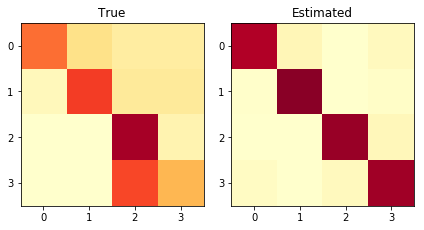

JS divergence: 0.1527	Norm Frobenius: 0.2469
Groups probabilities:  [0.8692 0.029  0.1017]


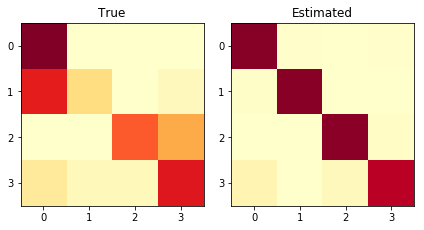

JS divergence: 0.1883	Norm Frobenius: 0.2971
Groups probabilities:  [0.8979 0.0886 0.0135]


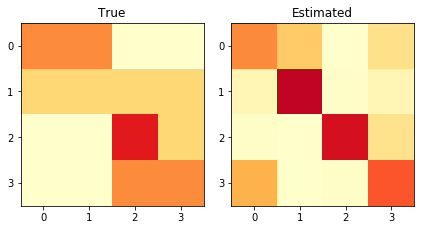

JS divergence: 0.2101	Norm Frobenius: 0.2462
Groups probabilities:  [0.0506 0.4395 0.5099]


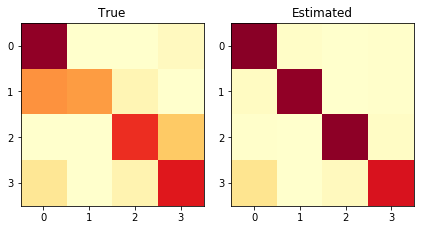

JS divergence: 0.1032	Norm Frobenius: 0.1979
Groups probabilities:  [0.7824 0.2013 0.0163]


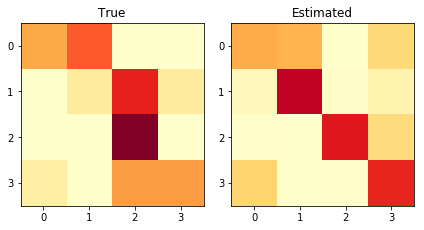

JS divergence: 0.2706	Norm Frobenius: 0.3131
Groups probabilities:  [0.0624 0.3071 0.6305]


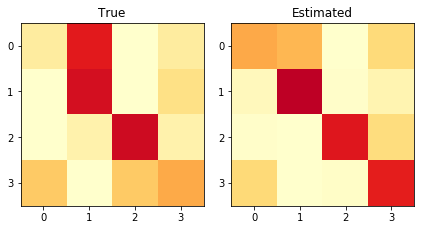

JS divergence: 0.0984	Norm Frobenius: 0.1758
Groups probabilities:  [0.0934 0.2881 0.6185]


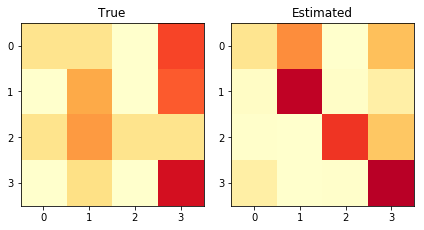

JS divergence: 0.2221	Norm Frobenius: 0.2769
Groups probabilities:  [0.0085 0.1313 0.8602]


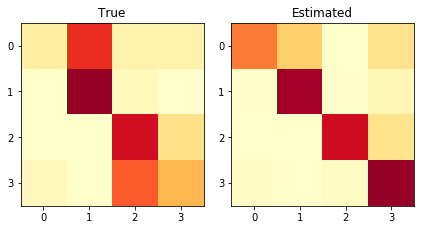

JS divergence: 0.1524	Norm Frobenius: 0.2572
Groups probabilities:  [0.4941 0.0247 0.4812]


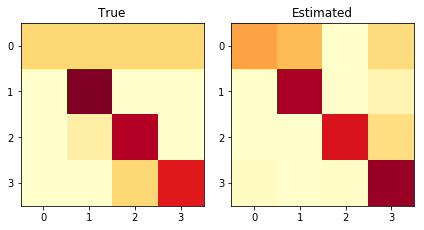

JS divergence: 0.1150	Norm Frobenius: 0.1322
Groups probabilities:  [0.369  0.0365 0.5945]


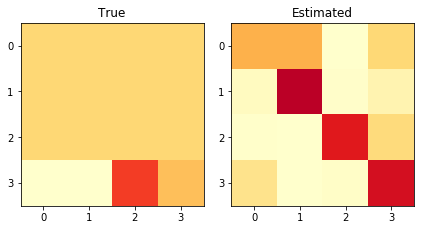

JS divergence: 0.3119	Norm Frobenius: 0.3234
Groups probabilities:  [0.1333 0.2187 0.648 ]


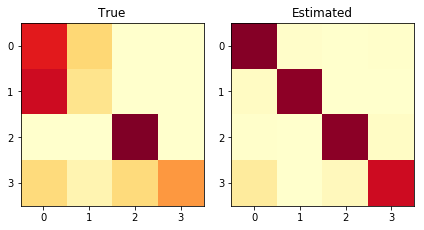

JS divergence: 0.2043	Norm Frobenius: 0.3106
Groups probabilities:  [0.8323 0.1579 0.0099]


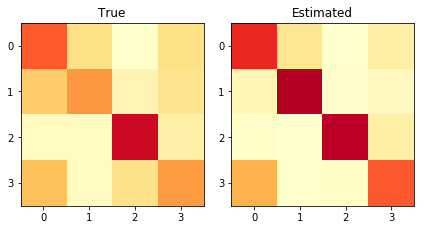

JS divergence: 0.0661	Norm Frobenius: 0.1441
Groups probabilities:  [0.2734 0.4362 0.2904]


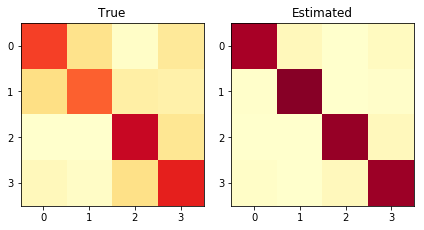

JS divergence: 0.0928	Norm Frobenius: 0.1597
Groups probabilities:  [0.9008 0.0171 0.082 ]


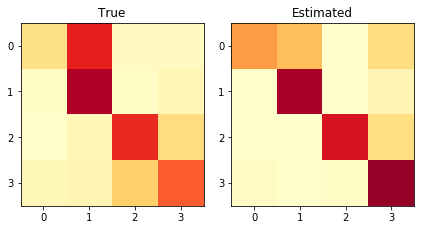

JS divergence: 0.0882	Norm Frobenius: 0.1700
Groups probabilities:  [0.3894 0.0323 0.5782]


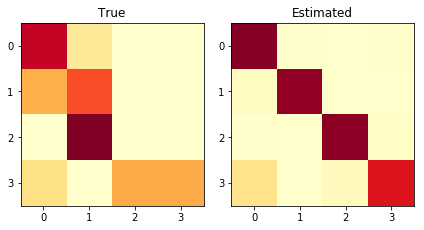

JS divergence: 0.3428	Norm Frobenius: 0.3935
Groups probabilities:  [0.7726 0.2153 0.0121]
Calculate confusion matrix on global version


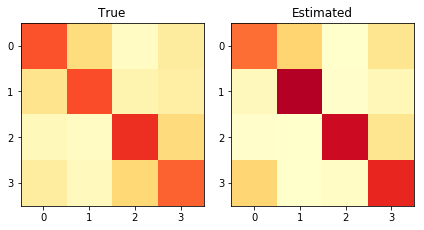

JS divergence: 0.0596	Norm Frobenius: 0.1143
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(G) NormF,(G) JS
0,All,0.6855,0.6855,0.6642,0.2786,0.2397,0.1143,0.0596


Val


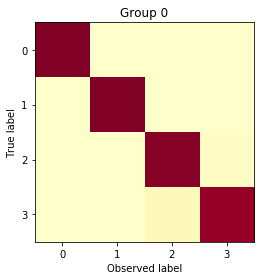

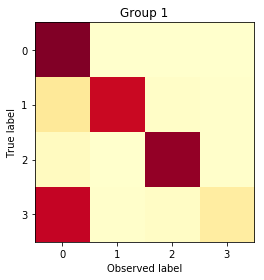

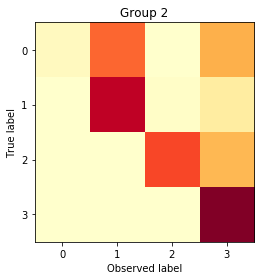

Inertia JS: 0.31377889128227826
Inertia NormF: 0.3553775649822834
A result


,Groups,Prob,Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.2420,0.0899,0.9809,0.9903,0.9745,0.0076,2,0.3138,0.3554,0.6574,0.6574
1,1,0.3035,0.3126,0.7281,0.7923,0.6375,0.2767,0,0.3138,0.3554,0.6115,0.6115
2,2,0.4544,0.4932,0.6349,0.7092,0.5132,0.2003,3,0.3138,0.3554,0.4614,0.4614


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.661,0.661,0.6373


In [172]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=False,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual1 multiples runs***") #lambda = 1

print("Train")
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)


print("Val")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val,data=Z_val_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual3 multiples runs***
Train
Calculate confusion matrix on repeat version


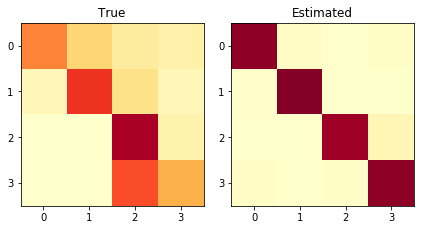

JS divergence: 0.1910	Norm Frobenius: 0.2673
Groups probabilities:  [0.0336 0.     0.9664]


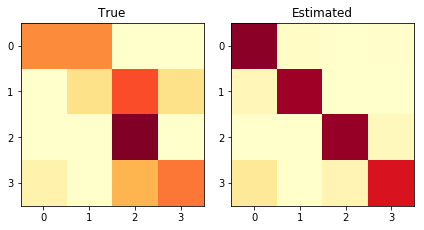

JS divergence: 0.2512	Norm Frobenius: 0.3154
Groups probabilities:  [0.2841 0.     0.7159]


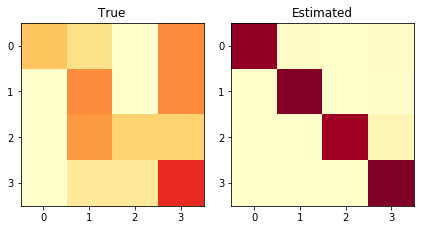

JS divergence: 0.3069	Norm Frobenius: 0.3502
Groups probabilities:  [5.000e-04 4.900e-03 9.947e-01]


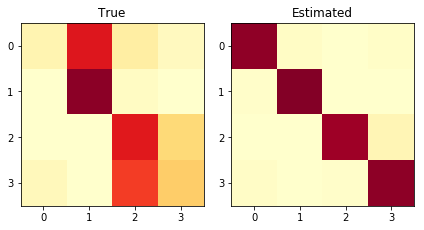

JS divergence: 0.3044	Norm Frobenius: 0.3812
Groups probabilities:  [0.0312 0.     0.9688]


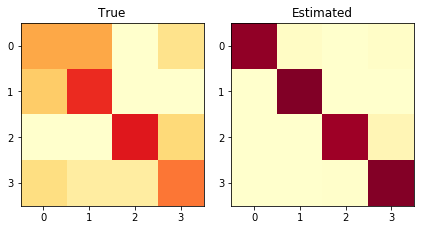

JS divergence: 0.1874	Norm Frobenius: 0.2483
Groups probabilities:  [0.0025 0.     0.9975]


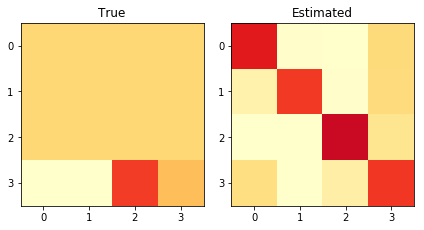

JS divergence: 0.2985	Norm Frobenius: 0.3139
Groups probabilities:  [0.4223 0.2375 0.3402]


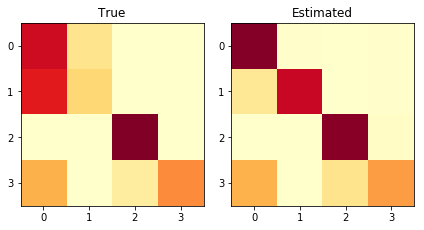

JS divergence: 0.0939	Norm Frobenius: 0.2187
Groups probabilities:  [0.7415 0.     0.2585]


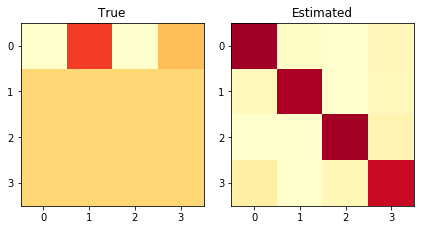

JS divergence: 0.4834	Norm Frobenius: 0.4331
Groups probabilities:  [0.2203 0.0434 0.7363]


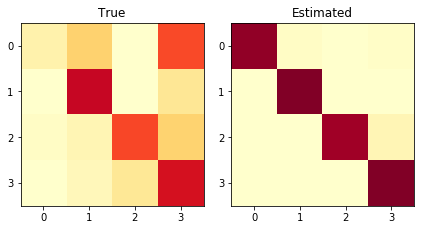

JS divergence: 0.2398	Norm Frobenius: 0.3018
Groups probabilities:  [0. 0. 1.]


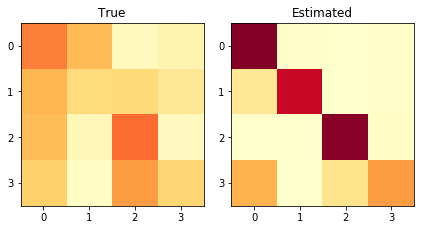

JS divergence: 0.2242	Norm Frobenius: 0.2777
Groups probabilities:  [0.7346 0.     0.2654]


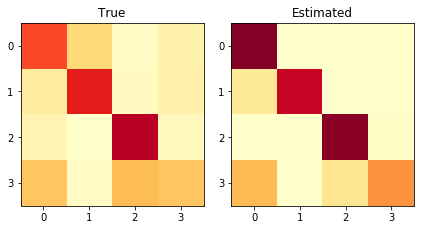

JS divergence: 0.0762	Norm Frobenius: 0.1324
Groups probabilities:  [0.6917 0.     0.3083]


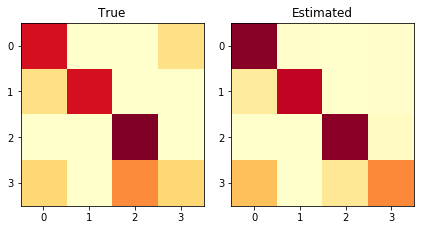

JS divergence: 0.0555	Norm Frobenius: 0.1298
Groups probabilities:  [0.6502 0.     0.3498]


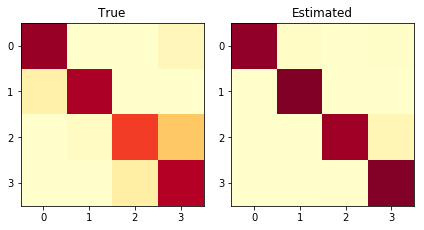

JS divergence: 0.0507	Norm Frobenius: 0.1033
Groups probabilities:  [0.0026 0.     0.9974]


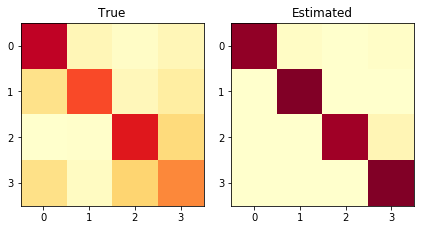

JS divergence: 0.1373	Norm Frobenius: 0.1927
Groups probabilities:  [0. 0. 1.]


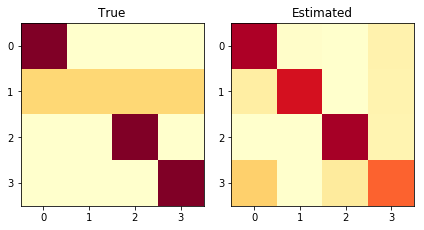

JS divergence: 0.1528	Norm Frobenius: 0.2099
Groups probabilities:  [0.5519 0.0827 0.3653]
Calculate confusion matrix on global version


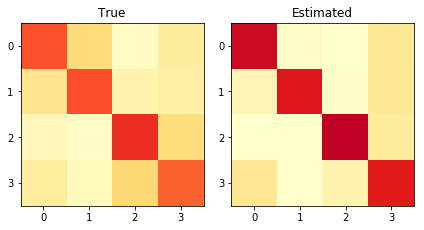

JS divergence: 0.0658	Norm Frobenius: 0.1189
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(G) NormF,(G) JS
0,All,0.6877,0.6877,0.6762,0.2909,0.2554,0.1189,0.0658


Val


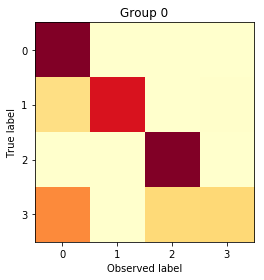

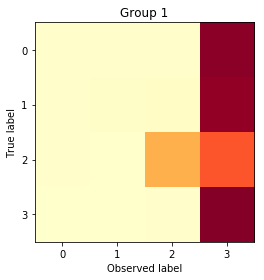

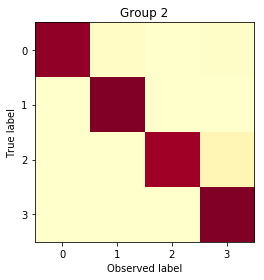

Inertia JS: 0.46039892536607957
Inertia NormF: 0.44236856900251925
A result


,Groups,Prob,Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.3282,0.4233,0.7553,0.8317,0.6737,0.1740,0,0.4604,0.4424,0.6021,0.6021
1,1,0.1609,0.2849,0.3481,0.4185,0.1308,0.8284,3,0.4604,0.4424,0.6072,0.6072
2,2,0.5109,0.1269,0.9718,0.9856,0.9624,0.0193,3,0.4604,0.4424,0.6074,0.6074


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.6068,0.6068,0.5942


In [47]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=False,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***") #lambda = 1

print("Train")
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)


print("Val")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val,data=Z_val_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [43]:
plot_alphas(gMixture_Ind1.alphas_training)

NameError: name 'plot_alphas' is not defined

In [44]:
plot_alphas(gMixture_Ind3.alphas_training)

NameError: name 'plot_alphas' is not defined

### project confusion matrices

In [42]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_IT = flatten_conf(gMixture_Ind1.get_confusionM())
centroids_plot_IK = flatten_conf(gMixture_Ind3.get_confusionM())
global_plot = (confe_matrix_G.flatten()).reshape(1,-1)

from sklearn.decomposition import PCA
model = PCA(2)
model.fit(to_plot) 

to_plot = model.transform(to_plot) 
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_IT = model.transform(centroids_plot_IT)
centroids_plot_IK = model.transform(centroids_plot_IK)
global_plot = model.transform(global_plot)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo

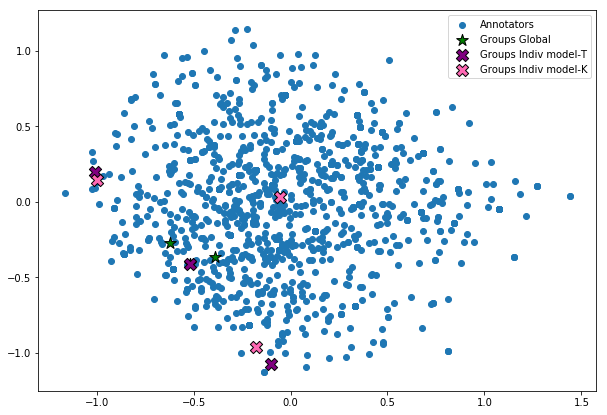

In [43]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo